Visualize the gridsearch results for updated TOC and CaCO3 datasets. Also the performance and data distribution. The updated datasets and this workflow are developed after discussion at AWI with Lester (20201209).

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

#plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = True

%matplotlib inline

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

# TOC

In [10]:
from sklearn.model_selection import train_test_split

merge_df = pd.read_csv('data/spe+bulk_dataset_20201215.csv', index_col=0)
# All data points contain TOC
X = merge_df.iloc[:, : -5].values
X = X / X.sum(axis = 1, keepdims = True)
y = merge_df['TOC%'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

## Basic infos

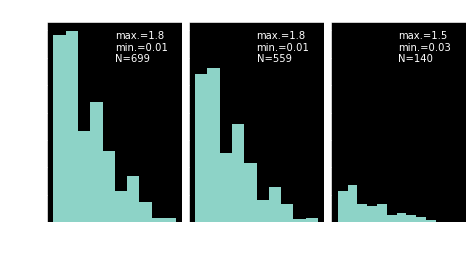

In [40]:
fig, axes = plt.subplots(1, 3, sharex='row', sharey='row', figsize=(7.5, 3.5))
for ax, y, label in zip(axes, [merge_df['TOC%'], y_train, y_test], ['Whole dataset', 'Training set', 'Test set']):
    ax.hist(y)
    ax.text(0.5, 0.8, "max.={:.1f}\nmin.={:.2f}\nN={}".format(
        np.max(y), np.min(y), len(y)), transform=ax.transAxes)
    ax.set_xlabel('wt (%)\n{}'.format(label))

axes[0].set_ylabel('Count')

fig.suptitle('Data distribution (TOC)')
fig.subplots_adjust(wspace=.05, top=.92)
fig.savefig('results/toc_hist_{}.png'.format(date))

## Gridsearch results

In [2]:
result_df = pd.read_csv('results/toc_grid_nmf+svr_20201215.csv', index_col = 0)

In [3]:
print(len(result_df), len(result_df[result_df.mean_test_score > 0]))

392 264


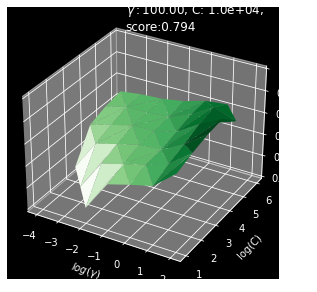

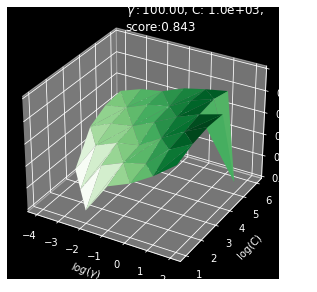

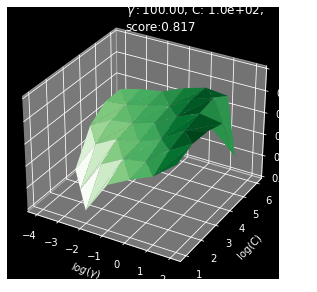

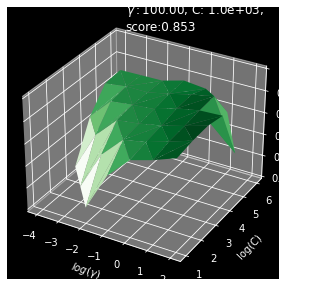

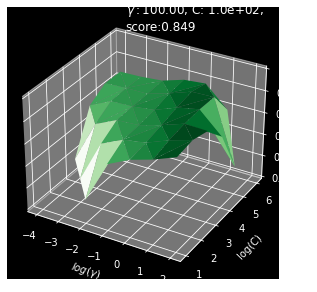

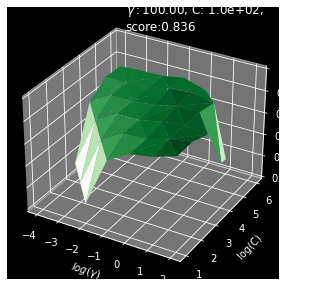

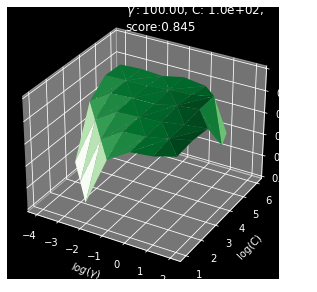

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

for n_components in np.unique(result_df.param_nmf__n_components):
    data = result_df[(result_df.param_nmf__n_components == n_components) & (result_df.mean_test_score > 0)].reset_index(drop = True)
    fig = plt.figure(figsize = (7.3,5))
    ax = fig.gca(projection='3d')
    xx = data.param_svr__gamma.astype(float)
    yy = data.param_svr__C.astype(float)
    zz = data.mean_test_score.astype(float)
    max_index = np.argmax(zz)

    surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)

    #ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
    text = '{} components\n$\gamma :{:.2f}$, C: {:.1e},\nscore:{:.3f}'.format(n_components, xx[max_index], yy[max_index], zz[max_index])
    ax.text(-3, 5, 1.2, text, fontsize=12)
    
    ax.set_zlim(0, 1)
    ax.set_zticks(np.linspace(0, 1, 6))
    ax.set_xlabel('$log(\gamma)$')
    ax.set_ylabel('log(C)')
    ax.set_zlabel('CV score')
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    fig.savefig('results/toc_grid_{}nmr+svr_3D_{}.png'.format(n_components, date))

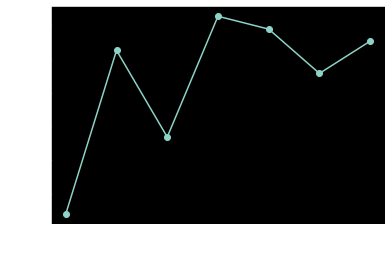

In [8]:
scores = []
for n in np.unique(result_df.param_nmf__n_components):
    data = result_df[result_df.param_nmf__n_components == n]
    rank_min = data.rank_test_score.min()
    scores = np.hstack((scores, data.loc[data.rank_test_score == rank_min, 'mean_test_score'].values))
    
plt.plot(np.unique(result_df.param_nmf__n_components), scores, marker='o')
plt.xlabel('Amount of components')
plt.ylabel('Best CV score')
plt.savefig('results/toc_scores_components_{}.png'.format(date))

## Evaluation on test set

In [9]:
from joblib import dump, load
svr = load('models/toc_nmf+svr_model_20201215.joblib')

In [11]:
y_predict = np.exp(svr.predict(X_test))

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error

print('Scores in the test set:')
print('R2 = {:.3f} .'.format(r2_score(y_test, y_predict)))
print('The mean absolute error is {:.3f} (%, concetration).'.format(mean_absolute_error(y_test, y_predict)))
print('The max. residual error is {:.3f} (%, concetration).'.format(max_error(y_test, y_predict)))

Scores in the test set:
R2 = 0.854 .
The mean absolute error is 0.089 (%, concetration).
The max. residual error is 0.666 (%, concetration).


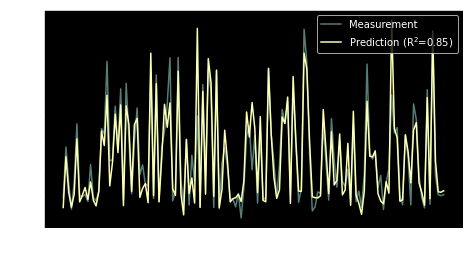

In [14]:
plt.figure(figsize=(7.5, 4))
plt.plot(range(len(y_predict)), y_test, alpha=0.6, label='Measurement')
plt.plot(range(len(y_predict)), y_predict, label='Prediction (R$^2$={:.2f})'.format(r2_score(y_test, y_predict)))
plt.ylabel('TOC concentration (%)')
plt.xlabel('Sample no.')
plt.legend(loc = 'upper right')
plt.savefig('results/toc_predictions_nmr+svr_{}.png'.format(date))

# TOC RF
Instead of using NMF+SVR as before, I tried NMF+RF to overcome the imbalanced distribution issue (the test set might need to be redesigned). However, RF has defet in extrapolation. The work (grid_toc_rf.py) is submited by submit_rf.sh. P.S. I tried only RF, the test scores are not as good as with NMF.

In [19]:
result_df = pd.read_csv('results/toc_grid_nmf+rf_20201216.csv', index_col = 0)
result_df

,n_estimators,max_depth,score_train,score_test
0,100,5,0.853429,0.767094
1,1000,5,0.860248,0.775819
2,10000,5,0.860514,0.777932
3,100,10,0.938233,0.785486
4,1000,10,0.942241,0.792262
5,10000,10,0.942726,0.793185
6,100,20,0.970894,0.784658
7,1000,20,0.971666,0.791275
8,10000,20,0.971576,0.792284
9,100,35,0.971881,0.785456


Hmm...overall they have over-fitting problem.

In [22]:
result_df.iloc[np.argmax(result_df.score_test), :]

n_estimators    10000.000000
max_depth          10.000000
score_train         0.942726
score_test          0.793185
Name: 5, dtype: float64

In [25]:
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

rf = make_pipeline(NMF(n_components=9, max_iter = 8000, random_state = 24), 
                     RandomForestRegressor(n_estimators=10000, max_depth=10, n_jobs=-1, random_state=24))
rf.fit(X_train, np.log(y_train))

Pipeline(steps=[('nmf', NMF(max_iter=8000, n_components=9, random_state=24)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_estimators=10000,
                                       n_jobs=-1, random_state=24))])

In [27]:
y_predict = np.exp(rf.predict(X_test))

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error

print('Scores in the test set:')
print('R2 = {:.3f} .'.format(r2_score(y_test, y_predict)))
print('The mean absolute error is {:.3f} (%, concetration).'.format(mean_absolute_error(y_test, y_predict)))
print('The max. residual error is {:.3f} (%, concetration).'.format(max_error(y_test, y_predict)))

Scores in the test set:
R2 = 0.894 .
The mean absolute error is 0.081 (%, concetration).
The max. residual error is 0.446 (%, concetration).


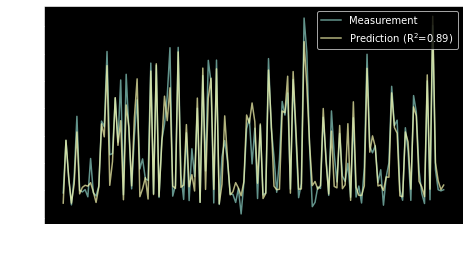

In [34]:
plt.figure(figsize=(7.5, 4))
plt.plot(range(len(y_predict)), y_test, alpha=.7, label='Measurement')
plt.plot(range(len(y_predict)), y_predict, alpha=.7, label='Prediction (R$^2$={:.2f})'.format(r2_score(y_test, y_predict)))
plt.ylabel('TOC concentration (%)')
plt.xlabel('Sample no.')
plt.legend(loc = 'upper right')
plt.savefig('results/toc_predictions_nmr+rf_{}.png'.format(date))

The result is already pretty good!

In [26]:
from joblib import dump, load
dump(rf, 'models/toc_nmf+rf_model_{}.joblib'.format(date)) 

['models/toc_nmf+rf_model_20201216.joblib']

# CaCO3

In [15]:
from sklearn.model_selection import train_test_split

merge_df = pd.read_csv('data/spe+bulk_dataset_20201215.csv', index_col=0)
merge_df = merge_df[merge_df.core != 'SO178-12-3']
X = merge_df.iloc[:, : -5].values
X = X / X.sum(axis = 1, keepdims = True)
y = merge_df['CaCO3%'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

## Basic infos

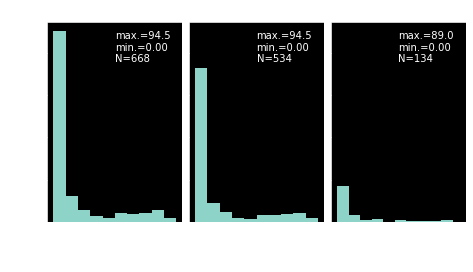

In [38]:
fig, axes = plt.subplots(1, 3, sharex='row', sharey='row', figsize=(7.5, 3.5))
for ax, y, label in zip(axes, [merge_df['CaCO3%'], y_train, y_test], ['Whole dataset', 'Training set', 'Test set']):
    ax.hist(y)
    ax.text(0.5, 0.8, "max.={:.1f}\nmin.={:.2f}\nN={}".format(
        np.max(y), np.min(y), len(y)), transform=ax.transAxes)
    ax.set_xlabel('wt (%)\n{}'.format(label))

axes[0].set_ylabel('Count')

fig.suptitle(r'Data distribution ($CaCO{_3}$)')
fig.subplots_adjust(wspace=.05, top=.92)
fig.savefig('results/caco3_hist_{}.png'.format(date))

There are zeros in the data. Let's check.

In [12]:
merge_df[merge_df['CaCO3%'] == 0]

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,TC%,TOC%,CaCO3%,core,mid_depth_mm
441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,1.0380,0.0,LV28-44-3,2675.0
462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.4500,0.0,LV28-44-3,3725.0
465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.4750,0.0,LV28-44-3,3875.0
466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.5395,0.0,LV28-44-3,3925.0
470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.6570,0.0,LV28-44-3,4125.0
474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.7650,0.0,LV28-44-3,4325.0
476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.6430,0.0,LV28-44-3,4425.0
477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.6080,0.0,LV28-44-3,4475.0
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.6505,0.0,LV28-44-3,4825.0
486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.6310,0.0,LV28-44-3,4875.0


I replace them by 0.01 to avoid infinity problem when applying logrithm.

## Gridsearch results

In [16]:
result_df = pd.read_csv('results/caco3_grid_nmf+svr_20201216.csv', index_col = 0)

In [17]:
print(len(result_df), len(result_df[result_df.mean_test_score > 0]))

294 231


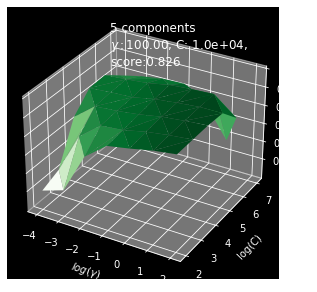

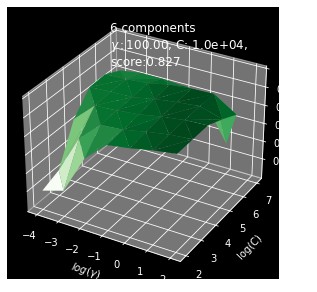

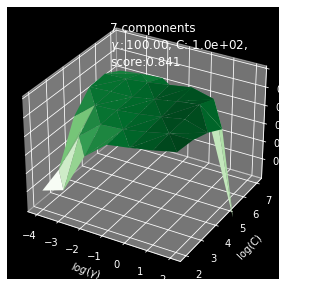

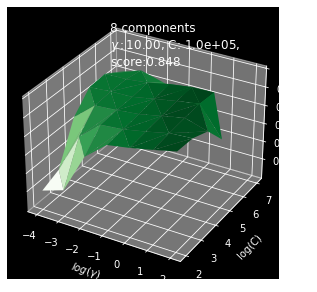

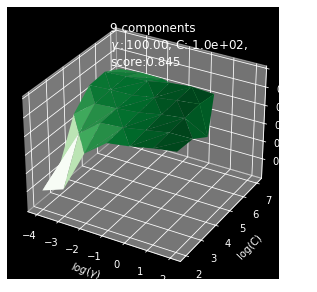

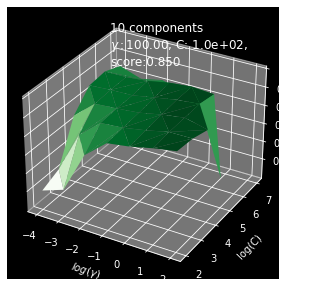

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

for n_components in np.unique(result_df.param_nmf__n_components):
    data = result_df[(result_df.param_nmf__n_components == n_components) & (result_df.mean_test_score > -0.5)].reset_index(drop = True)
    fig = plt.figure(figsize = (7.3,5))
    ax = fig.gca(projection='3d')
    xx = data.param_svr__gamma.astype(float)
    yy = data.param_svr__C.astype(float)
    zz = data.mean_test_score.astype(float)
    max_index = np.argmax(zz)

    surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)

    #ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
    text = '{} components\n$\gamma :{:.2f}$, C: {:.1e},\nscore:{:.3f}'.format(n_components, xx[max_index], yy[max_index], zz[max_index])
    ax.text(-3, 5, 1, text, fontsize=12)
    
    ax.set_zlim(-.2, 1)
    ax.set_zticks(np.linspace(0, 1, 6))
    ax.set_xlabel('$log(\gamma)$')
    ax.set_ylabel('log(C)')
    ax.set_zlabel('CV score')
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    fig.savefig('results/caco3_grid_{}nmr+svr_3D_{}.png'.format(n_components, date))

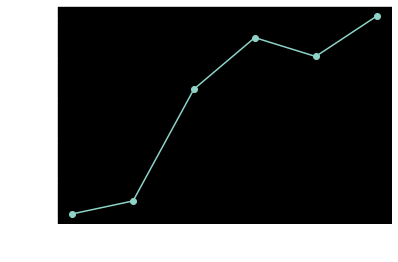

In [30]:
scores = []
for n in np.unique(result_df.param_nmf__n_components):
    data = result_df[result_df.param_nmf__n_components == n]
    rank_min = data.rank_test_score.min()
    scores = np.hstack((scores, data.loc[data.rank_test_score == rank_min, 'mean_test_score'].values))
    
plt.plot(np.unique(result_df.param_nmf__n_components), scores, marker='o')
plt.xlabel('Amount of components')
plt.ylabel('Best CV score')
plt.savefig('results/caco3_scores_components_{}.png'.format(date))

## Evaluation on test set

In [31]:
y = merge_df['CaCO3%'].replace(0, 0.01).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

from joblib import dump, load
svr = load('models/caco3_nmf+svr_model_20201216.joblib')

In [32]:
y_predict = np.exp(svr.predict(X_test))

In [33]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error

print('Scores in the test set:')
print('R2 = {:.3f} .'.format(r2_score(y_test, y_predict)))
print('The mean absolute error is {:.3f} (%, concetration).'.format(mean_absolute_error(y_test, y_predict)))
print('The max. residual error is {:.3f} (%, concetration).'.format(max_error(y_test, y_predict)))

Scores in the test set:
R2 = 0.977 .
The mean absolute error is 2.095 (%, concetration).
The max. residual error is 15.786 (%, concetration).


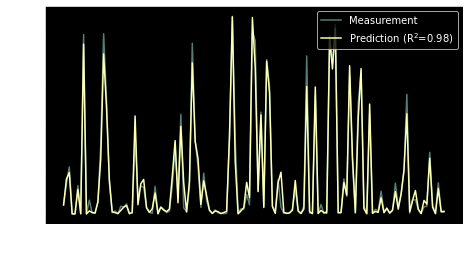

In [34]:
plt.figure(figsize=(7.5, 4))
plt.plot(range(len(y_predict)), y_test, alpha=0.6, label='Measurement')
plt.plot(range(len(y_predict)), y_predict, label='Prediction (R$^2$={:.2f})'.format(r2_score(y_test, y_predict)))
plt.ylabel(r'CaCO${_3}$ concentration (%)')
plt.xlabel('Sample no.')
plt.legend(loc = 'upper right')
plt.savefig('results/caco3_predictions_nmr+svr_{}.png'.format(date))